# Image Classification
## Date: 12/10/2019

###  Description: 
#### - Image classification is a common task for deep learning and neural networks (NN).
#### - The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining the image type.
#### - In this notebook we will first look into non NN based model to classify images and further look into deeper NN based models to improve the performance of classification

### Data Source: We will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes.


---------------------------------------------------------------------------------------------------------------------------

# Step 1: Source and Prepare Data

In [1]:
# Download important libraries
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False  #  Remove the grid lines from the image
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)

import os
from os import path
import tarfile

In [110]:
# Setting Seaborn graph style
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("poster", rc={'grid.color': 'black', "grid.linewidth": 2, 'lines.markersize':15})

In [2]:
# Get the zipped file from source url - https://www.cs.toronto.edu/~kriz/cifar.html
def get_raw_file(url):
    import re
    fname = re.split('/',url)[-1]
    dname = './Data/RawData/'
    fpath = dname+fname
    if path.exists(fpath):
        print('File exists')
        return fpath
    else:
        import wget
        os.makedirs(dname, exist_ok=True) 
        wget.download(url, fpath, bar=False)
        print('File Downloaded')
        return fpath

In [3]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
file_path = get_raw_file(url)

File exists


In [4]:
def unzip(fpath):
    dpath = './Data/cifar-10-batches-py/'
    if path.exists(dpath):
        print('Files exist')
    else:       
        with tarfile.open(fpath) as tar:
            tar.extractall(path = './Data/')
            tar.close()
            print('Files Unzipped')
unzip(file_path)

Files exist


In [5]:
# The unzippped files are pickled and split dictionaries
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [6]:
#  Let us now load the training and test datasets
def load_datasets(path,files):
    train, train_labels, classes, test, test_labels = [], [], [], [], []
    
    for file in files:
        
        #Load the train datasets that have 'data' in the filename
        if 'data' in file:
            data = unpickle(path+file)['data']
            reshaped_data = (data.reshape(len(data),3,32,32)).transpose(0,2,3,1) # Reshape to 32x32x3 pixels for each image
            train.append(reshaped_data)
            y = unpickle(path+file)['labels']
            train_labels.append(y)
            
        # Load the image labels
        if 'batches' in file:
            classes = unpickle(path+file)['label_names']
        
        #Load the test datasets that have 'test' in the filename
        if 'test' in file:
            test_data = unpickle(path+file)['data']
            reshaped_data = test_data.reshape(len(test_data),3,32,32).transpose(0,2,3,1)
            test.append(reshaped_data)
            test_labels = unpickle(path+file)['labels']
            
            
            
    X_train  = (np.concatenate(train).astype('float32'))/255.
    y_train = np.concatenate(train_labels)
    X_test = np.concatenate(test).astype('float32')/255.
    y_test = np.asarray(test_labels)
    
    return X_train, y_train,X_test, y_test, classes

In [7]:
# Loading the train and test datasets
from os import listdir
from os.path import isfile, join
path = './Data/cifar-10-batches-py/'
files = [f for f in listdir(path) if isfile(join(path, f))]
train, labels,X_test, y_test, image_classes = load_datasets(path,files)

# Let us look at the data

In [8]:
def plot_sample(X, y, type,i):
    from random import randint
    from random import seed
    seed(i)
    index = randint(0, len(X)-1)
    label = y[index]
    return X[index],image_classes[label]  

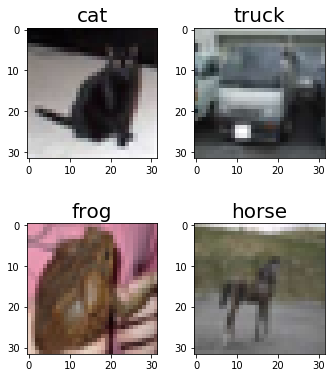

In [9]:
# Plotting 4 random images within the train dataset
fig, ax = plt.subplots(2, 2, figsize=(6,6))
fig.subplots_adjust(hspace = .5, wspace=.001)

for i in range(4):
    np.ravel(ax)[i].imshow(plot_sample(train, labels, type,i*10)[0])
    np.ravel(ax)[i].set_title(plot_sample(train, labels, type,i*10)[1], fontsize=20)

In [10]:
import collections
print ('Train Label Count:\n', collections.Counter(labels))
print ('Test Label Count:\n', collections.Counter(y_test))

Train Label Count:
 Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
Test Label Count:
 Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


## Predict majority/single class 

* Since both train and test data are balanced between all classes, predicting a single class would result in 10% accuracy
* Let us look at other ways to predict image class

## Perceptual Delta

Since we already have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  To do this, we need to develop a metric to determine the distance between two images.  We'll make the simplifying (and completely wrong) assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

While we could just take RMS difference of the red, green, and blue pixels, let's be slightly more sophisticated and look at human vision for a metric.  After all, we're pretty good at image classifications, so there might be some useful optimization here.

It turns out that modeling human perception is [extraordinarily complicated](https://en.wikipedia.org/wiki/Color_difference#CIEDE2000).  We're going to use a [simplified model](https://www.compuphase.com/cmetric.htm):

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.



Let us build a graph that takes in a series of images, as well as a base image, and returns a result containing the $\Delta C$ value (for each pixel) between the base image and each image in the series.  

(Note that the intention here in our solution is that `images` will be a stack of images, while `base` is a single image.  Since the function is decorated with `tf.function` the computations within the function will be recorded in a computation graph and the output from this function will be a tensor.)


In [11]:
@tf.function

def delta_func(images, base):
    delR = images[:,:,:,0] - base[:,:,0]
    delG = images[:,:,:,1] - base[:,:,1]
    delB = images[:,:,:,2] - base[:,:,2]
    R_bar = (images[:,:,:,0] + base[:,:,0])/2
    CM = (tf.sqrt(2*(delR**2) + 4*(delG**2) + 3*(delB**2) + R_bar*((delR**2)-(delB**2)) ))/(32**2)
    deltas = (tf.reduce_sum(CM, [1,2]))
    return deltas

## Smallest delta model

While we can calculate the delta between each image, a pragmatic approach would be to create a 'typical' image for each class and use the delta function as a metric to predict each class (lowest delta between image and typical image = predicted class).This problem will have two steps

1.The first step is to train a typical image for each class in the training set

2.The second step will be to make predictions on the test set.These predictions will be based on the closest "typical" image trained in the first step.

Let us first generate a "typical" image for each image class.  This typical image will be the one that minimizes the total (or average) perceptual delta from all training images in this class.  We could do that through some clever averaging, but let's treat it as a minimization problem so that we can do gradient descent.  

### Create Typical Image

Let us make the typical image a TensorFlow variable, starting with random pixel values.  It's this TensorFlow variable that we will train by performing gradient descent.

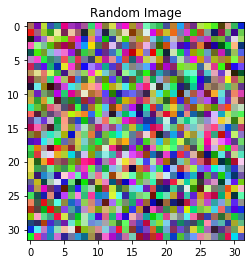

In [12]:
rand_image = tf.Variable(tf.random.uniform([32,32,3],dtype=tf.float32))
plt.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
plt.imshow(rand_image.numpy())
plt.title('Random Image')
plt.show()

In [13]:
from tensorflow import keras
optimizer =  keras.optimizers.SGD(lr=10)
    
def loss(lab_img, return_func=False):
    
    def loss_():
        return tf.reduce_mean(delta_func(lab_img, typ_image))
    if not return_func:
        return loss_()
        
    return loss_

In [14]:
def generate_typical_images(lab_img,typ_img, n_iter=100):
    # Create Random Image
    for _ in range(n_iter):     
        optimizer.minimize(loss(lab_img ,return_func=True), [typ_image])
    return typ_image

## Now let us create a typical image of a frog and see the resemblence

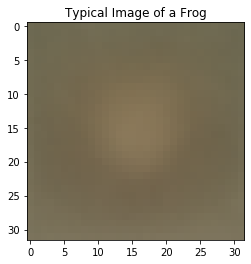

In [15]:
label = 6
lab_img =  train[labels==label]
typ_image = tf.Variable(tf.random.uniform([32,32,3],dtype=tf.float32))
typ_frog_image = generate_typical_images(lab_img,typ_image, n_iter=200)
plt.imshow(typ_frog_image.numpy())
plt.title('Typical Image of a Frog')
plt.show()

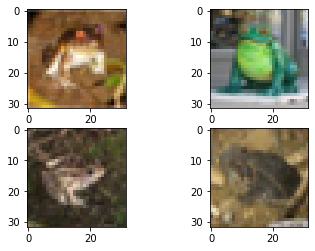

In [16]:
frogs = np.where(labels == 6)[0]   #  Get the indices for the frogs

fig, ax = plt.subplots(2, 2)
for i in range(4):
    np.ravel(ax)[i].imshow(train[ frogs[i] ])

plt.show()

#### Resemblence 

- Not really, but this is best we can do to create typical images

Let us now create a typical image for each class

In [17]:
from os import path

dname = './Data/Typical Images/'
fname = 'Typical Images.npy'
fpath = dname+fname
if path.exists(fpath):
        typical_images = np.load(fpath)
else:
    typ_images = []
    for i in range(10):
        lab_img = train[labels==i]
        typ_image = tf.Variable(tf.random.uniform([32,32,3],dtype=tf.float32))
        typ_image = generate_typical_images(lab_img,typ_image, n_iter=100)
        typ_images.append(typ_image)
    typical_images = tf.convert_to_tensor( typ_images )
    os.makedirs(dname, exist_ok=True) 
    np.save(fpath, typical_images)

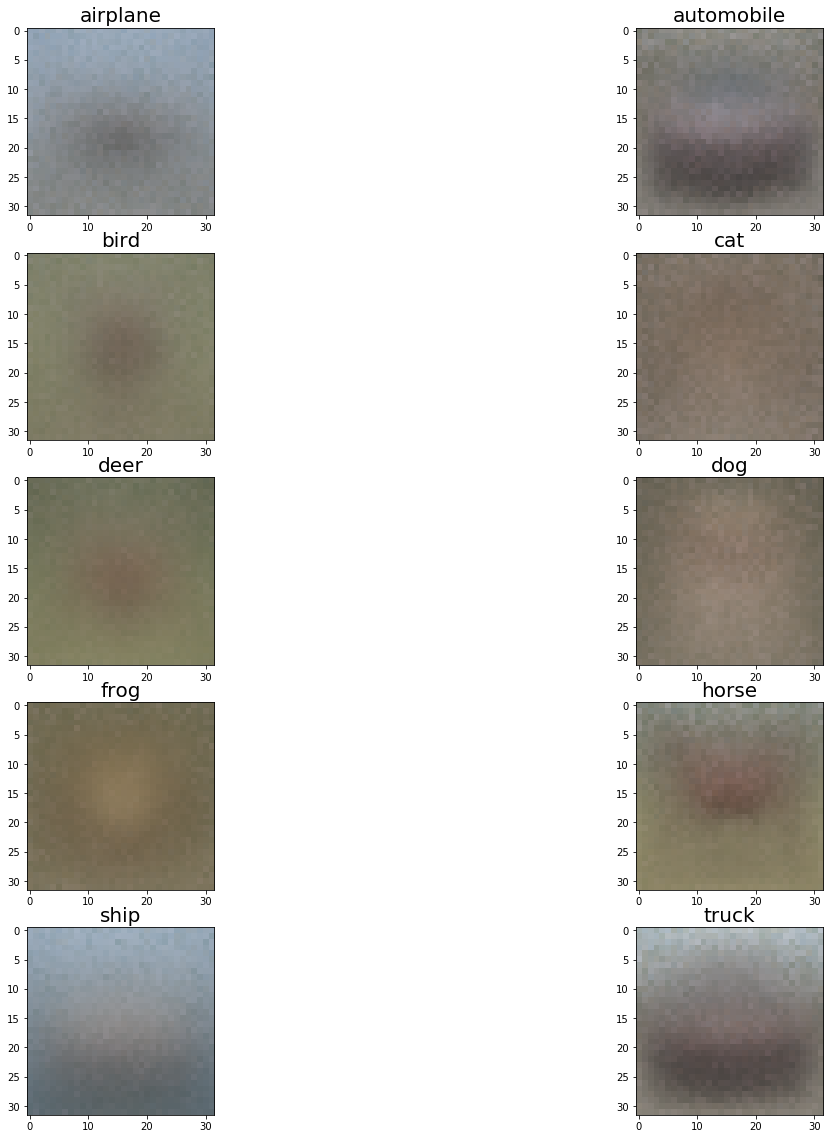

In [18]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 2,figsize=(20,20))
for i in range(10):
    np.ravel(ax)[i].imshow(typical_images[i])
    np.ravel(ax)[i].set_title(image_classes[i], fontsize=20)
plt.show()

We see that

* Typical image of Horse has some remblence 
* Typical image of automobile and truck look similar to each other

### Prediction based on the closest image

Let us create a error function that takes in each image from test dataset and calculates the closest typical image class and uses it to predict the image class.

In [19]:
@tf.function
def error_fn(images, base=typ_image):
    return tf.reduce_mean((delta_func(images,base), [1,2]))

In [20]:
error_list=[]
for i in range(10):
    error = delta_func(X_test,typical_images[i])
    error_list.append(error)
error_array = np.array(error_list).T
pred_delta_model = np.argmin(error_array, axis =1)

In [21]:
from sklearn.metrics import accuracy_score

accuracy_del_model = accuracy_score(y_test,pred_delta_model)
print('The accuracy of the delta model is ', accuracy_del_model*100, '%')

The accuracy of the delta model is  28.76 %


### Smallest Delta Model

* Prediction accuracy of 28% was acheived which is still better than 10% obtained with predicting a single class

Let us look at the confusion matrix to see how our model performs with different classes. Rows represent actual classes, while columns represent predicted classes.

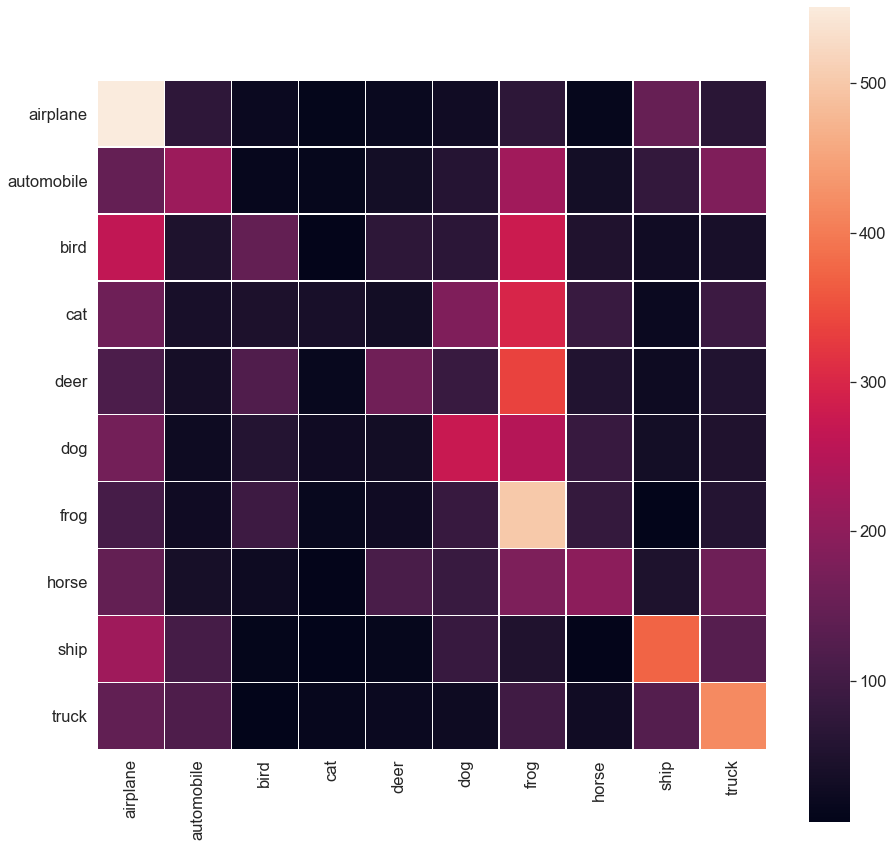

In [22]:
from sklearn.metrics import confusion_matrix
conf_mx_delta = confusion_matrix(y_test, pred_delta_model)
fig = plt.figure(figsize=(15,15))
sns.set(font_scale=1.5)
sns.heatmap(conf_mx_delta, annot=False, square=True,xticklabels=image_classes,yticklabels=image_classes, linewidths=.5)

### Results

* While smallest delta model has improved efficiency it is still very low <30% 
* Seems like many images are misclassified as frog and airplane


We will make use of more deeper models using Neural Networks to see if we can improve classification accuracy

## Fully-connected model

The previous model (delta model) still makes the assumption that this distance metric is the right measure to use.  In the next model, we'll give this up.  Let us build a multi-layer fully-connected neural network that takes the pixel values as input and yields a class prediction as output.


In [23]:
fc_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32,3]),
    keras.layers.Dense(300, activation="elu"),

    keras.layers.Dense(150, activation="elu"),
    keras.layers.Dense(10, activation="softmax")
])

In [24]:
# Let us split the training dataset to train and validation
X_valid, X_train = train[:1000], train[1000:] 
y_valid, y_train = labels[:1000], labels[1000:]

In [25]:
keras.backend.clear_session()

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
fc_model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam', metrics=["accuracy"])
dpath = './Data/Model/'
os.makedirs(dpath, exist_ok=True)
checkpoint_fc_model = keras.callbacks.ModelCheckpoint(dpath+'fc_model.h5', save_best_only=True)

history_fc = fc_model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid), 
                          verbose=1, callbacks=[checkpoint_fc_model])

Train on 49000 samples, validate on 1000 samples
Epoch 1/20
49000/49000 [==============================] - 5s 107us/sample - loss: 1.8871 - accuracy: 0.3220 - val_loss: 1.7357 - val_accuracy: 0.3570
Epoch 2/20
49000/49000 [==============================] - 4s 87us/sample - loss: 1.6728 - accuracy: 0.3977 - val_loss: 1.6088 - val_accuracy: 0.4290
Epoch 3/20
49000/49000 [==============================] - 4s 85us/sample - loss: 1.5914 - accuracy: 0.4302 - val_loss: 1.6277 - val_accuracy: 0.4050
Epoch 4/20
49000/49000 [==============================] - 4s 85us/sample - loss: 1.5404 - accuracy: 0.4473 - val_loss: 1.5895 - val_accuracy: 0.4220
Epoch 5/20
49000/49000 [==============================] - 4s 87us/sample - loss: 1.5001 - accuracy: 0.4629 - val_loss: 1.5287 - val_accuracy: 0.4480
Epoch 6/20
49000/49000 [==============================] - 5s 99us/sample - loss: 1.4719 - accuracy: 0.4716 - val_loss: 1.5050 - val_accuracy: 0.4450
Epoch 7/20
49000/49000 [==============================] 

In [158]:
def plot_history(history):
    pd.DataFrame(history.history).plot(figsize=(12, 10))
    plt.grid(True)
    plt.gca().set_ylim(0, 2)
    plt.show()
    

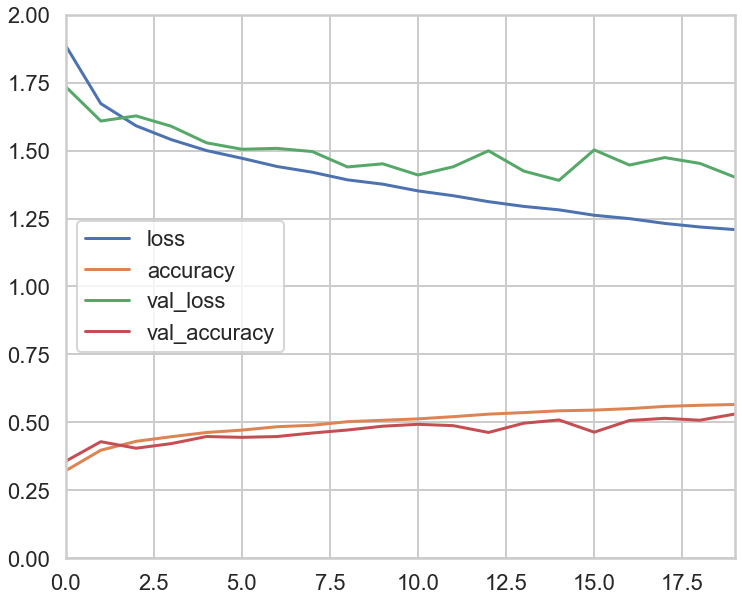

In [159]:
plot_history(history_fc)

In [133]:
def get_accuracy_pred(model,test_data,y_test,get_pred=False):
    from sklearn.metrics import accuracy_score
    pred = model.predict_classes(test_data)
    if get_pred == True:
        return pred
    accuracy = accuracy_score(y_test,pred)
    return accuracy

In [134]:
fc_model = keras.models.load_model(dpath+'fc_model.h5')
print('The accuracy of Fully Connected NN model is', get_accuracy_pred(fc_model,X_test,y_test))

The accuracy of Fully Connected NN model is 0.5064


In [128]:
def plot_heatmap(model,y_test,pred,normalize=False):
    from sklearn.metrics import confusion_matrix
    fig = plt.figure(figsize=(15,15))
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        np.fill_diagonal(norm_conf_mx, 0)
        sns.heatmap(norm_conf_mx, annot=False, square=True,
                    xticklabels=image_classes,yticklabels=image_classes, 
                    linewidths=.5)
        
    else:
        sns.heatmap(conf_mx, annot=False, square=True,
                    xticklabels=image_classes,yticklabels=image_classes, 
                    linewidths=.5)
        

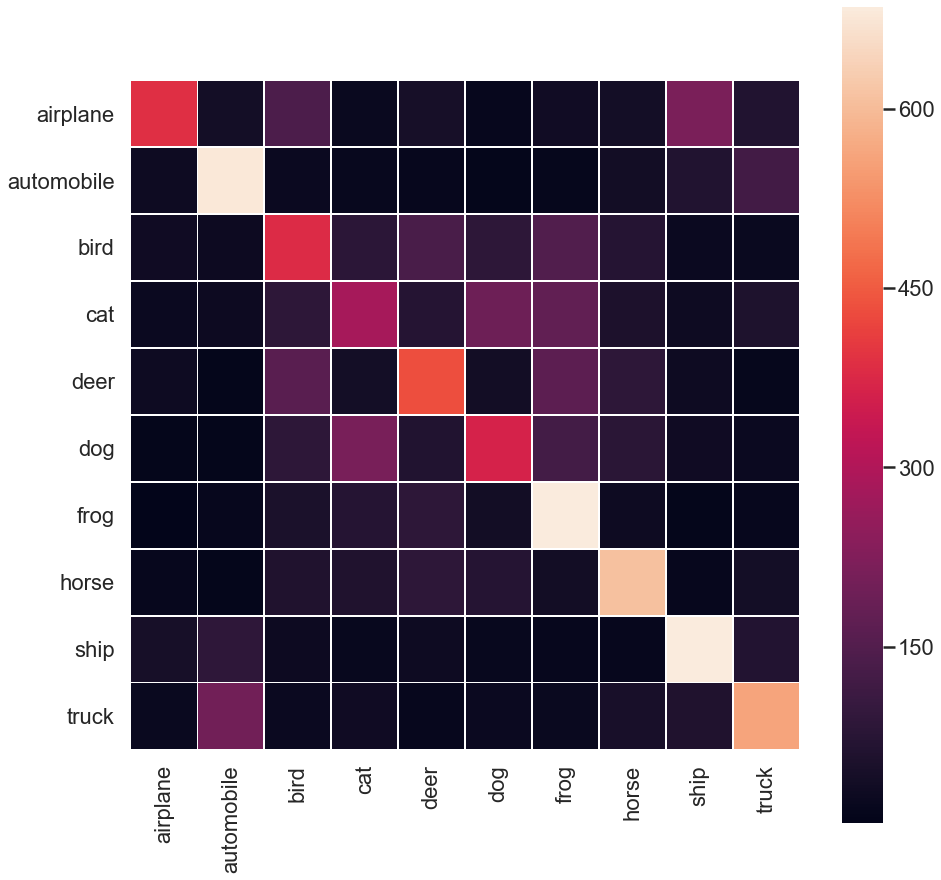

In [130]:
pred_fc_model = get_accuracy(fc_model,X_test,y_test,get_pred=True)
plot_heatmap(fc_model,y_test,pred_fc_model)

### While the above heatmap shows the overall classification/misclassification between classes,it would be more insightful to normalize and remove the correct classifications. This will emphasize the misclassification between classes only making it easy to visualize where our model falls short


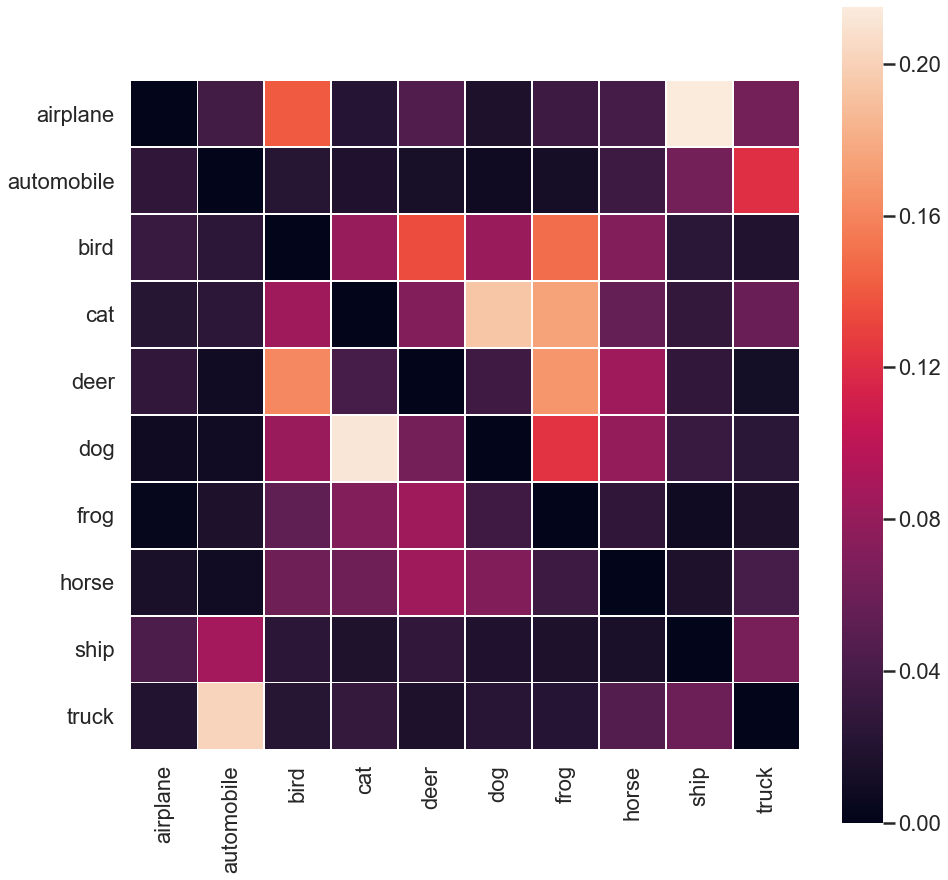

In [131]:
plot_heatmap(fc_model,y_test,pred_fc_model, normalize=True)

## Fully Connected NN Model Results
 
***

* **After training with 20 epochs, we get an accuracy of ~50%. Obtained accuracy with NN approach much higher than delta model (which was ~ 28%)**

* **We still see many animals misclassified as frogs. Model is also failing at dog-cat distinction**
* **Truck and automobile are also misclassified as each other**
***


***
## Convolutional NN Model
***
Convolutional neural networks have had a lot of success in image classification. Let us build a neural network with convolutional layers to improve the performance.

In [50]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,kernel_size=3, activation='relu', padding="SAME")

cnn_model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=3, input_shape=[32, 32, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax'),
])

## CNN Model
Let us go through the CNN model that we built:

* The first layer uses 64  filters (4 × 4) but no stride because the input images are not very large. It also sets the input_shape=[32, 32, 3]

* Next we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.

* Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter that can be tuned).

* The number of filters increases from 64 to 128 and then to 256 as we progress through the CNN toward the output layer. This filter enhancement is required since the number of low-level features is  fairly low.

* We also further add dropout regularization (10%) after each fully connected dense layers

In [51]:
# The data needs to be scaled for CNN model

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True)
X_train_sc = (X_train - X_mean) / X_std
X_val_sc = (X_valid - X_mean) / X_std
X_test_sc = (X_test - X_mean) / X_std


In [52]:
keras.backend.clear_session()
optimizer = keras.optimizers.Adam()

cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
dpath = './Data/Model/'
os.makedirs(dpath, exist_ok=True)
checkpoint_cnn_model = keras.callbacks.ModelCheckpoint(dpath+'cnn_model.h5', save_best_only=True)

history_cnn = cnn_model.fit(X_train_sc, y_train, epochs=10, validation_data=[X_val_sc, y_valid],
                            verbose=1, callbacks=[checkpoint_cnn_model])

Train on 49000 samples, validate on 1000 samples
Epoch 1/10
49000/49000 [==============================] - 17s 356us/sample - loss: 1.4353 - accuracy: 0.4736 - val_loss: 1.0775 - val_accuracy: 0.6050
Epoch 2/10
49000/49000 [==============================] - 17s 346us/sample - loss: 0.9045 - accuracy: 0.6792 - val_loss: 0.7982 - val_accuracy: 0.7200
Epoch 3/10
49000/49000 [==============================] - 17s 345us/sample - loss: 0.7058 - accuracy: 0.7526 - val_loss: 0.8085 - val_accuracy: 0.7020
Epoch 4/10
49000/49000 [==============================] - 17s 351us/sample - loss: 0.5693 - accuracy: 0.8019 - val_loss: 0.6682 - val_accuracy: 0.7530
Epoch 5/10
49000/49000 [==============================] - 16s 330us/sample - loss: 0.4565 - accuracy: 0.8402 - val_loss: 0.7151 - val_accuracy: 0.7630
Epoch 6/10
49000/49000 [==============================] - 17s 342us/sample - loss: 0.3698 - accuracy: 0.8712 - val_loss: 0.6946 - val_accuracy: 0.7710
Epoch 7/10
49000/49000 [=====================

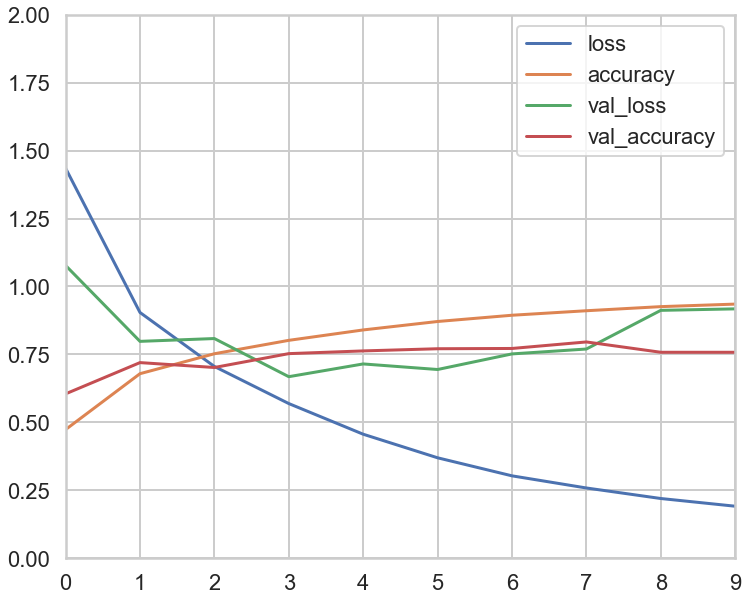

In [160]:
plot_history(history_cnn)

In [161]:
cnn_model = keras.models.load_model(dpath+'cnn_model.h5')
print('The accuracy of Convolutional NN Model is', get_accuracy_pred(cnn_model,X_test_sc,y_test))

The accuracy of Convolutional NN Model is 0.755


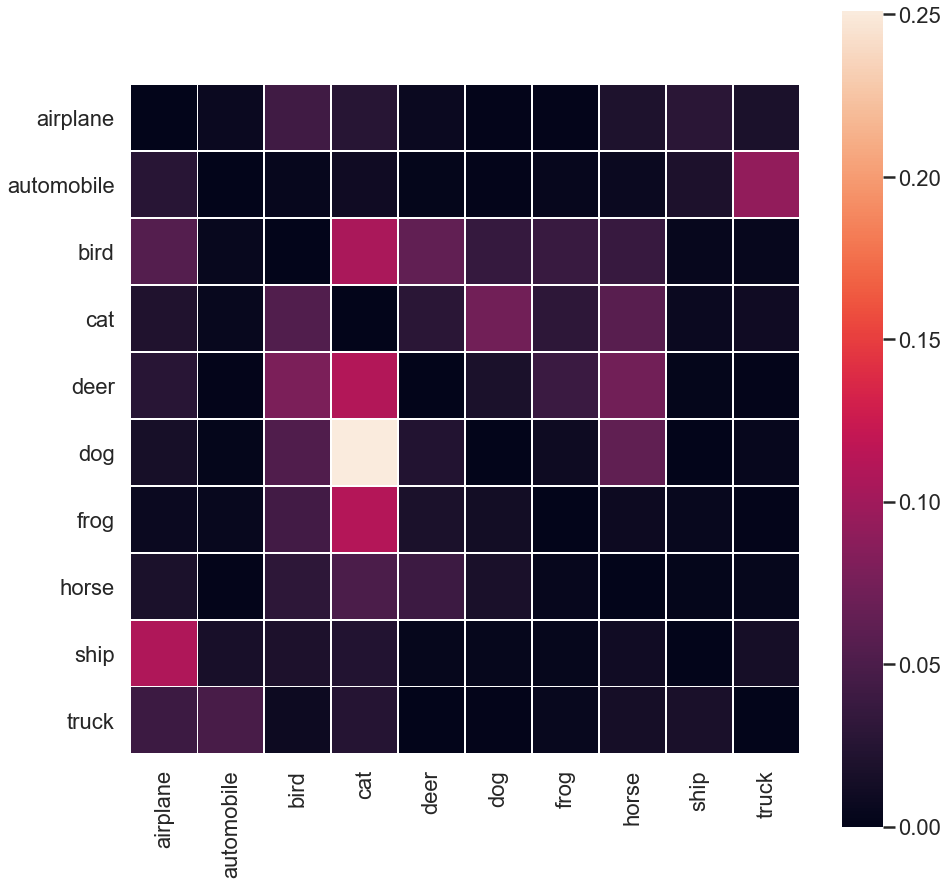

In [162]:
pred_cnn_model  = get_accuracy_pred(cnn_model,X_test_sc,y_test,get_pred=True)
plot_heatmap(cnn_model,y_test,pred_cnn_model,normalize=True)

## CNN Model Results
 
***

* **After training with 20 epochs, we get an accuracy of ~75%, significant improvement over our FC-NN model**

* **Frog misclassifications observed in FC-NN models have been significantly reduced**
* **Of all the misclassifications, dog-cat errors seem to be dominant**
***

In [163]:
import matplotlib as mpl
def plot_images(instances, images_per_row=4, **options):
    size = 32
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size,3) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, **options)
    plt.axis("off")

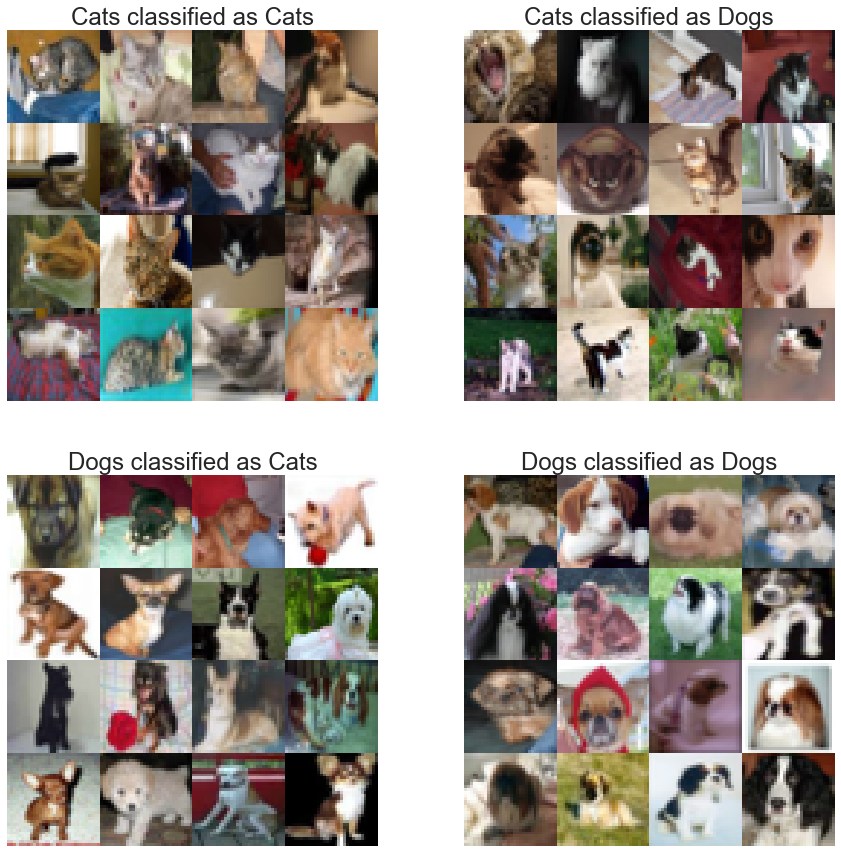

In [164]:
cl_a, cl_b = 3, 5
X_aa = X_test[(y_test == cl_a) & (pred_cnn_model == cl_a)]
X_ab = X_test[(y_test == cl_a) & (pred_cnn_model == cl_b)]
X_ba = X_test[(y_test == cl_b) & (pred_cnn_model == cl_a)]
X_bb = X_test[(y_test == cl_b) & (pred_cnn_model == cl_b)]

plt.figure(figsize=(15,15))
ax1 = plt.subplot(221); plot_images(X_aa[:16], images_per_row=4)
ax1.title.set_text('Cats classified as Cats')
ax2 = plt.subplot(222); plot_images(X_ab[:16], images_per_row=4)
ax2.title.set_text('Cats classified as Dogs')
ax3 = plt.subplot(223); plot_images(X_ba[:16], images_per_row=4)
ax3.title.set_text('Dogs classified as Cats')
ax4 = plt.subplot(224); plot_images(X_bb[:16], images_per_row=4)
ax4.title.set_text('Dogs classified as Dogs')
plt.show()

## Next Steps

* Add more comments on CNN model (dropout, other layers)
* Transfer learning
* Look at the images are that wrongly classified

## Transfer Learning

In [165]:
test_file = [f for f in listdir(save_path) if isfile(join(save_path, f)) if 'Test_' in f]
test_file.sort()

test=[]
for file in test_file:
    fpath = save_path+file
    test.append(np.load(fpath))
X_test_reshaped =  np.concatenate(test)
X_test_reshaped.shape

(10000, 1, 2048)

In [166]:
train_file = [f for f in listdir(save_path) if isfile(join(save_path, f)) if 'Train_' in f]
#train_file.sort()

train_list=[]
for file in train_file:
    fpath = save_path+file
    train_list.append(np.load(fpath))
train_reshaped =  np.concatenate(train_list)
train_reshaped.shape

(50000, 1, 2048)

In [167]:
X_val_tl, X_train_tl = train_reshaped[:1000], train_reshaped[1000:] 
y_val_tl, y_train_tl = labels[:1000], labels[1000:]

In [168]:
tl_model = keras.models.Sequential([
  
    keras.layers.Dense(128, activation="relu",input_shape=[1,2048]),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

tl_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [169]:
dpath = './Data/Model/'
os.makedirs(dpath, exist_ok=True)
checkpoint_tl_model = keras.callbacks.ModelCheckpoint(dpath+'tl_model.h5', save_best_only=True)
history_tl = tl_model.fit(X_train_tl, y_train_tl,epochs=10,
                          verbose=1,validation_data=[X_val_tl,y_val_tl],
                          callbacks=[checkpoint_tl_model])

Train on 49000 samples, validate on 1000 samples
Epoch 1/10
49000/49000 [==============================] - 8s 169us/sample - loss: 0.6079 - accuracy: 0.7910 - val_loss: 0.4938 - val_accuracy: 0.8230
Epoch 2/10
49000/49000 [==============================] - 8s 156us/sample - loss: 0.4651 - accuracy: 0.8389 - val_loss: 0.4640 - val_accuracy: 0.8320
Epoch 3/10
49000/49000 [==============================] - 8s 155us/sample - loss: 0.4230 - accuracy: 0.8519 - val_loss: 0.5296 - val_accuracy: 0.8170
Epoch 4/10
49000/49000 [==============================] - 8s 159us/sample - loss: 0.3875 - accuracy: 0.8628 - val_loss: 0.4560 - val_accuracy: 0.8480
Epoch 5/10
49000/49000 [==============================] - 8s 159us/sample - loss: 0.3584 - accuracy: 0.8730 - val_loss: 0.4868 - val_accuracy: 0.8360
Epoch 6/10
49000/49000 [==============================] - 8s 160us/sample - loss: 0.3314 - accuracy: 0.8832 - val_loss: 0.4504 - val_accuracy: 0.8410
Epoch 7/10
49000/49000 [===========================

In [170]:
tl_model = keras.models.load_model(dpath+'tl_model.h5')
print('The accuracy of Convolutional NN Model is', get_accuracy_pred(tl_model,X_test_reshaped,y_test))

The accuracy of Convolutional NN Model is 0.8452


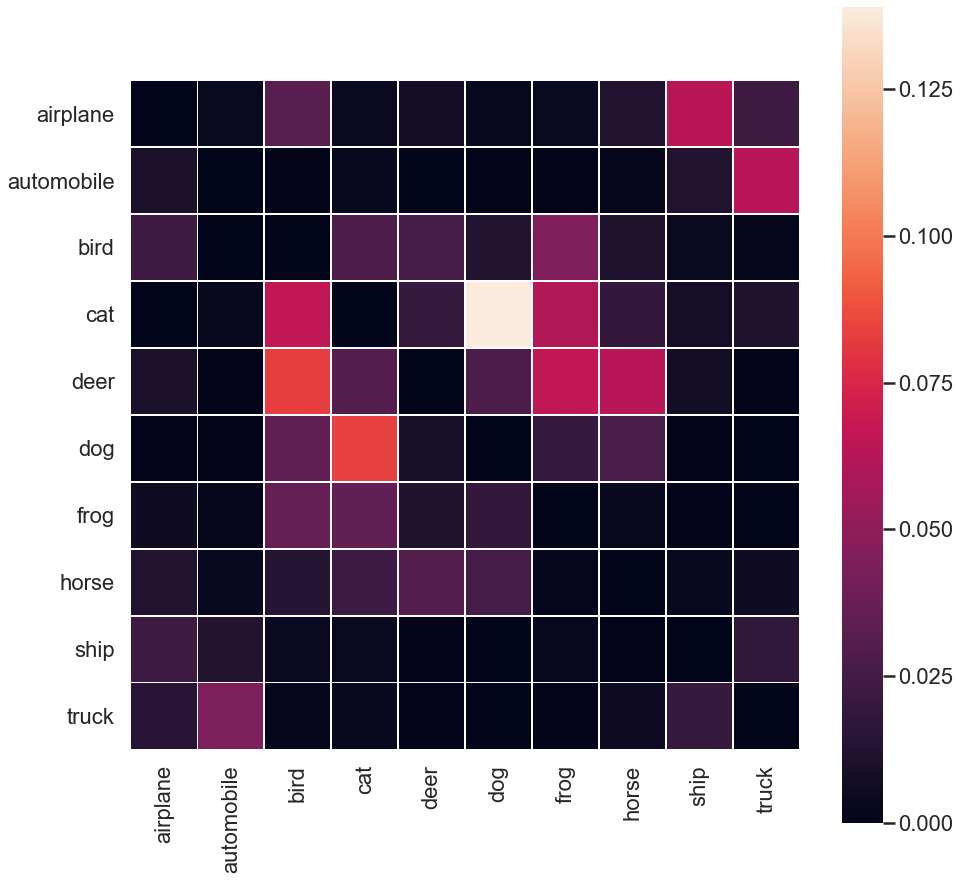

In [154]:
pred_tl_model  = get_accuracy_pred(tl_model,X_test_reshaped,y_test,get_pred=True)
plot_heatmap(tl_model,y_test,pred_tl_model,normalize=True)